In [15]:
library(MatchIt)
library(dplyr)
library(tidyr)
library(sparklyr)
library(ggplot2)
library(ggridges)
library(gridExtra)
library(Hmisc)
require(tidyverse)
require(grid)
library(effsize)
library(egg)
require(scales)

In [16]:
calc_vis <- function(df_total_anal)
{
    na_factor = 100
    a_factor = 100
    m_factor = 10
    v_factor = 10000
    d_factor = 1000 #mg compared to ug in orig. vis function
    df_total_anal[,paste("vis", "_baseline", sep = "")] <- df_total_anal$pm39_baseline * na_factor + df_total_anal$pm40_baseline * a_factor + df_total_anal$pm41_baseline * d_factor + df_total_anal$pm42_baseline * m_factor + df_total_anal$pm45_baseline * v_factor
    for (t in seq(0,3300,300)) {
        df_total_anal[,paste("vis", toString(t), sep = "_")] <- df_total_anal[,paste("pm39", toString(t), sep = "_")] * na_factor + df_total_anal[,paste("pm40", toString(t), sep = "_")] * a_factor + df_total_anal[,paste("pm41", toString(t), sep = "_")] * d_factor + df_total_anal[,paste("pm42", toString(t), sep = "_")] * m_factor + df_total_anal[,paste("pm45", toString(t), sep = "_")] * v_factor
    }
    return (df_total_anal)
}

calc_sv <- function(df_total_anal)
{
    df_total_anal[,paste("sv", "_baseline", sep = "")] <- df_total_anal$vm13_baseline / df_total_anal$vm1_baseline * 1000
    for (t in seq(0,3300,300)) {
        df_total_anal[,paste("sv", toString(t), sep = "_")] <- df_total_anal[,paste("vm13", toString(t), sep = "_")] / df_total_anal[,paste("vm1", toString(t), sep = "_")] * 1000
    }
    return (df_total_anal)
}

In [17]:
config <- spark_config()
config$`sparklyr.shell.driver-memory` <- "8G"
config$`sparklyr.shell.executor-memory` <- "8G"
sc <- spark_connect(master = "local", config = config)
spark_tbl_handle <- spark_read_parquet(sc, "bolus", "/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/psm_cardiac/2020-12-30/augmented/2022-01-14")
df_psm <- collect(spark_tbl_handle)

OUTPUT_PATH <- "./results/cardiac"

df_psm = calc_vis(df_psm)
df_psm = calc_sv(df_psm)

Warning message in file(input, encoding = "UTF-8"):
“'raw = FALSE' but '/cluster/home/config.yml' is not a regular file”
Warning message in readLines(con):
“cannot open file '/cluster/home/config.yml': Permission denied”
Re-using existing Spark connection to local



In [18]:
#bolus statistics
print ("##Fluid amount##")
summary(df_psm[df_psm$bolus == 1, ]$fluidamount)
print ("IQR")
IQR(df_psm[df_psm$bolus == 1, ]$fluidamount)
print ("##Duration min##")
summary(df_psm[df_psm$bolus == 1, ]$lenght*5)
print ("SD")
sd(df_psm[df_psm$bolus == 1, ]$lenght*5)

plot_count = qplot(df_psm[df_psm$bolus == 1, ]$fluidamount, geom="histogram") +
    scale_y_continuous(trans = "log10", labels = trans_format("log10", math_format(10^.x))) +
    xlab("Bolus size [ml]") +
    ylab("Count [log]") 
plot_duration = qplot(df_psm[df_psm$bolus == 1, ]$lenght*5, geom="histogram", binwidth=5) +
    xlab("Bolus duration [min]") +
    ylab("Count")
png(paste0(OUTPUT_PATH, "/", paste0("supp_figure2.png")), height = 600, width = 1200)   #pdf("path/to/file/PDFofG.pdf", height = 11, width = 8.5, paper = "letter")
ggarrange(plot_count, plot_duration, ncol=2, nrow=1)
dev.off()

[1] "##Fluid amount##"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  250.0   264.0   355.0   374.5   450.0  2011.0 

[1] "IQR"


[1] 186

[1] "##Duration min##"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   10.00   20.00   18.15   25.00   30.00 

[1] "SD"


[1] 8.963735

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8 rows containing missing values (geom_bar).”


png 
  2

In [19]:
#Betablocker usage
sum(df_psm[df_psm$bolus == 1, ]$dm_betablocker)/nrow(df_psm[df_psm$bolus == 1, ])
sum(df_psm[df_psm$bolus == 0, ]$dm_betablocker)/nrow(df_psm[df_psm$bolus == 0, ])

[1] 0.001959686

[1] 0.0002799552

<h1>Response models</h1>

In [20]:
calc_change_summary <- function(df_psm, column, column_name)
{
    print(column)
    #calculate maximum and median change (positive is increase)
    df_psm[,paste("max", column_name, sep="_")] = apply(df_psm[,c(paste(column, "0", sep="_"), paste(column, "300", sep="_"), paste(column, "600", sep="_"), paste(column, "900", sep="_"), paste(column, "1200", sep="_"), paste(column, "1500", sep="_"), paste(column, "1800", sep="_"), paste(column, "2100", sep="_"), paste(column, "2400", sep="_"), paste(column, "2700", sep="_"), paste(column, "3000", sep="_"), paste(column, "3300", sep="_"))], 1, max, na.rm=TRUE) - df_psm[,paste(column, "baseline", sep="_")]
    df_psm[,paste("median", column_name, sep="_")] = apply(df_psm[,c(paste(column, "0", sep="_"), paste(column, "300", sep="_"), paste(column, "600", sep="_"), paste(column, "900", sep="_"), paste(column, "1200", sep="_"), paste(column, "1500", sep="_"), paste(column, "1800", sep="_"), paste(column, "2100", sep="_"), paste(column,"2400", sep="_"), paste(column, "2700", sep="_"), paste(column, "3000", sep="_"), paste(column, "3300", sep="_"))], 1, median, na.rm=TRUE) - df_psm[,paste(column, "baseline", sep="_")]
    
    #set ratio to 1 if baseline value 0 and outcome values > 0
    baseline_zero_or_nd = df_psm[,paste(column, "baseline", sep="_")] == 0 | is.na(df_psm[,paste(column, "baseline", sep="_")])
    baseline_zero = df_psm[,paste(column, "baseline", sep="_")] == 0
    max_nd = is.na(df_psm[,paste("max", column, sep="_")])
    max_zero = df_psm[,paste("max", column, sep="_")] == 0
    
    #default values if one is missing
    df_psm[max_nd | max_zero | baseline_zero_or_nd, paste("ratio", column_name, sep="_")] = as.double(NA)
    if (column=="vis") {
        #special case of start of vasoactiva
        df_psm[!max_zero & baseline_zero_or_nd, paste("ratio", column_name, sep="_")] = 1.0
        df_psm[max_zero & baseline_zero_or_nd, paste("ratio", column_name, sep="_")] = 0.0
    }
    df_psm[!max_nd & !baseline_zero_or_nd, paste("ratio", column_name, sep="_")] = df_psm[!max_nd & !baseline_zero_or_nd,paste("max", column_name, sep="_")] / df_psm[!max_nd & !baseline_zero_or_nd,paste(column, "baseline", sep="_")]
    df_psm[!max_nd & !baseline_zero_or_nd, paste("ratio_bin", column_name, sep="_")] = df_psm[!max_nd & !baseline_zero_or_nd,paste("ratio", column_name, sep="_")] > 0.1
    df_psm
}

#calculate relative changes in variables
plot_vars = c('vm5', 'vm13', 'vis', 'sv')
for (variable in plot_vars){
    df_psm = calc_change_summary(df_psm, variable,variable)
}
df_psm$fluidamount100 <- df_psm$fluidamount/100
df_psm$bolus_rate <- df_psm$fluidamount / df_psm$lenght*12

[1] "vm5"
[1] "vm13"


Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

[1] "vis"
[1] "sv"


Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

In [24]:
df_psm$median_vm13_ml <- df_psm$median_vm13 * 1000
df_psm$vm13_baseline_ml <- df_psm$vm13_baseline * 1000

### MAP models

In [ ]:
#map model
model_map = "median_vm5 ~ sex_baseline + age_baseline + height_baseline + vm1_baseline + vm3_baseline + vm4_baseline + vm5_baseline + vm15_baseline + ventilated_baseline + vis_baseline + median_vis + bolus_rate:bolus + fluidamount100:bolus"
fit_map = lm(model_map, data=df_psm)
summary(fit_map)
confint(fit_map)
coef(fit_map)
hist(df_psm$median_vm5)
plot(fit_map, c(1,2))

## co model


Call:
lm(formula = model_co, data = df_psm)

Residuals:
    Min      1Q  Median      3Q     Max 
-1959.4  -276.6   -35.4   241.3  4290.7 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)   
(Intercept)          415.15870  517.59026   0.802  0.42262   
sex_baselineM        105.86016   34.30441   3.086  0.00207 **
age_baseline          -1.87926    1.20957  -1.554  0.12048   
height_baseline        3.06845    1.53141   2.004  0.04528 * 
vm1_baseline          -2.24941    4.18351  -0.538  0.59087   
vm3_baseline          -1.85214    1.89345  -0.978  0.32814   
vm4_baseline          -0.94406    3.46623  -0.272  0.78538   
vm5_baseline           4.79813    5.34811   0.897  0.36978   
vm13_baseline_ml      -0.18870    0.08810  -2.142  0.03236 * 
vm15_baseline         -5.54129    4.05626  -1.366  0.17211   
sv_baseline            3.77447    8.41333   0.449  0.65376   
ventilated_baseline  -21.21954   33.34951  -0.636  0.52469   
vis_baseline           0.04099    0.0320

,2.5 %,97.5 %
(Intercept),-6.001193e+02,1430.43674180
sex_baselineM,3.857042e+01,173.14990764
age_baseline,-4.251890e+00,0.49336460
height_baseline,6.451274e-02,6.07239162
vm1_baseline,-1.045557e+01,5.95675439
vm3_baseline,-5.566233e+00,1.86194315
vm4_baseline,-7.743239e+00,5.85512863
vm5_baseline,-5.692443e+00,15.28870534
vm13_baseline_ml,-3.615050e-01,-0.01589067
vm15_baseline,-1.349783e+01,2.41525441


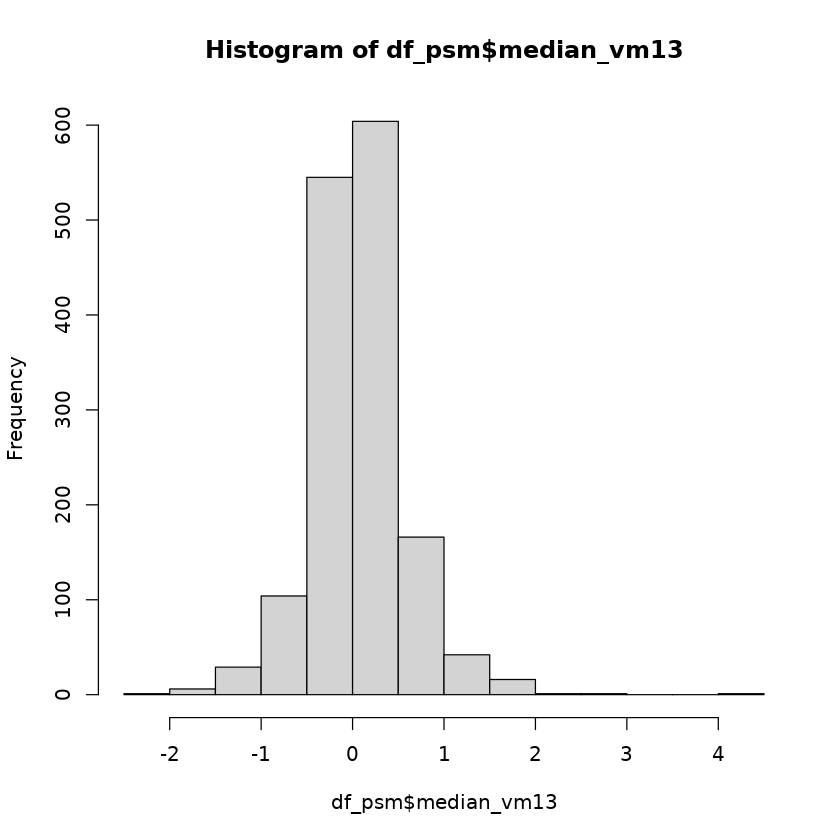

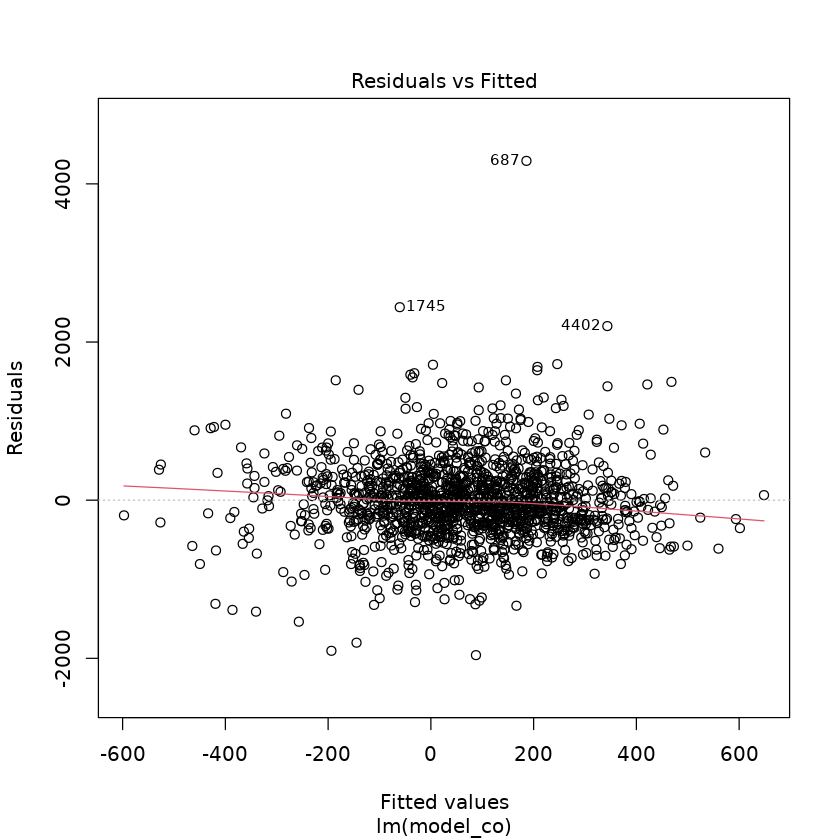

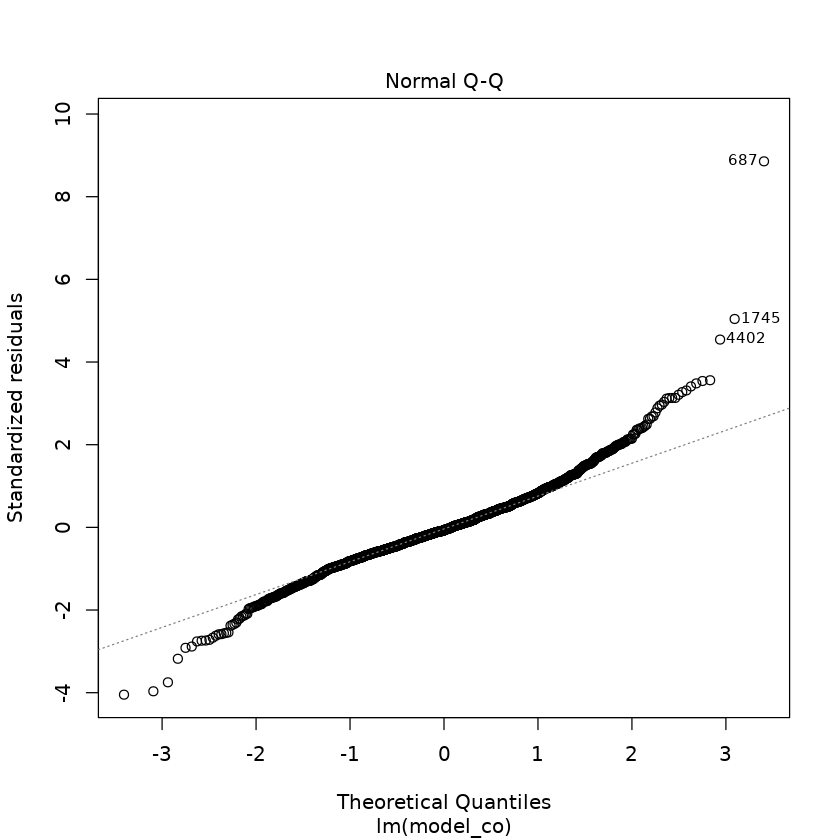

In [26]:
model_co = "median_vm13_ml ~ sex_baseline + age_baseline + height_baseline + vm1_baseline + vm3_baseline + vm4_baseline + vm5_baseline + vm13_baseline_ml + vm15_baseline + sv_baseline + ventilated_baseline + vis_baseline + bolus_rate:bolus + fluidamount100:bolus"
fit_co = lm(model_co, data=df_psm)
summary(fit_co)
confint(fit_co)
hist(df_psm$median_vm13)
plot(fit_co, c(1,2))


Call:
glm(formula = model_co, family = binomial(link = "logit"), data = df_psm %>% 
    filter(bolus == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1652  -1.1252   0.6824   0.9362   2.1090  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          7.897e+00  2.052e+00   3.849 0.000119 ***
sex_baselineM        8.291e-01  2.165e-01   3.830 0.000128 ***
age_baseline        -1.824e-02  7.685e-03  -2.373 0.017621 *  
height_baseline     -4.545e-03  9.454e-03  -0.481 0.630726    
vm1_baseline        -1.510e-02  8.337e-03  -1.811 0.070151 .  
vm3_baseline        -4.425e-03  1.202e-02  -0.368 0.712685    
vm4_baseline         1.735e-02  2.133e-02   0.813 0.416015    
vm5_baseline        -2.221e-02  3.285e-02  -0.676 0.499064    
vm13_baseline       -6.522e-01  8.725e-02  -7.475 7.73e-14 ***
vm15_baseline       -6.183e-02  2.612e-02  -2.368 0.017906 *  
ventilated_baseline  9.842e-02  2.046e-01   0.481 0.630494    
vis_ba

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),3.962942e+00,12.0336431479
sex_baselineM,4.083458e-01,1.2581792922
age_baseline,-3.353102e-02,-0.0033467607
height_baseline,-2.382709e-02,0.0135073945
vm1_baseline,-3.152198e-02,0.0012350055
vm3_baseline,-2.802177e-02,0.0191828520
vm4_baseline,-2.474822e-02,0.0591003841
vm5_baseline,-8.675721e-02,0.0423062670
vm13_baseline,-8.268629e-01,-0.4844904211
vm15_baseline,-1.134269e-01,-0.0109202778


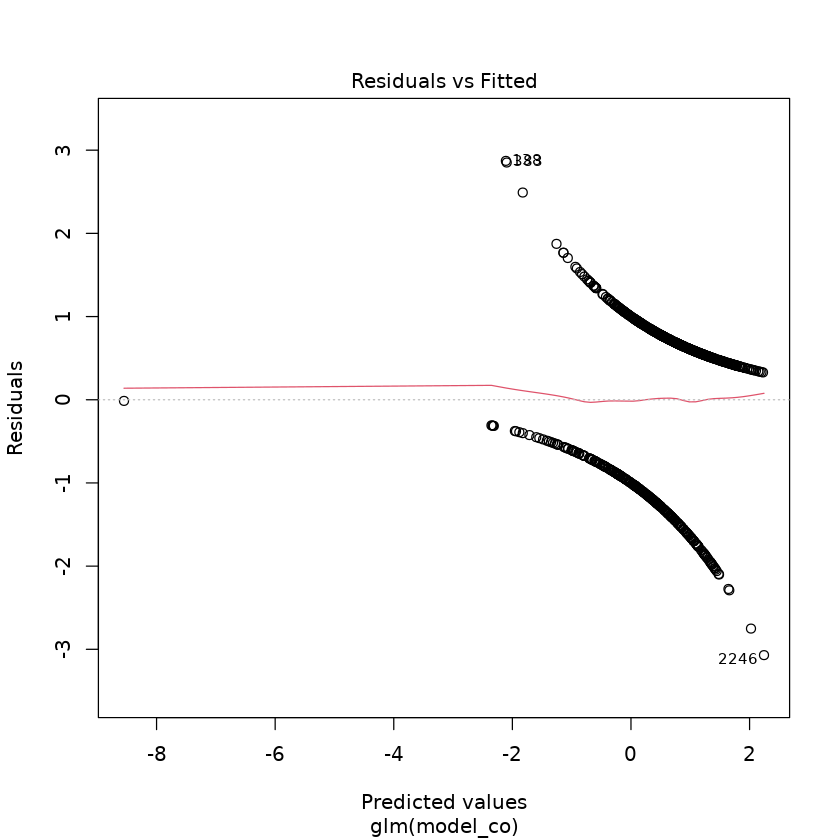

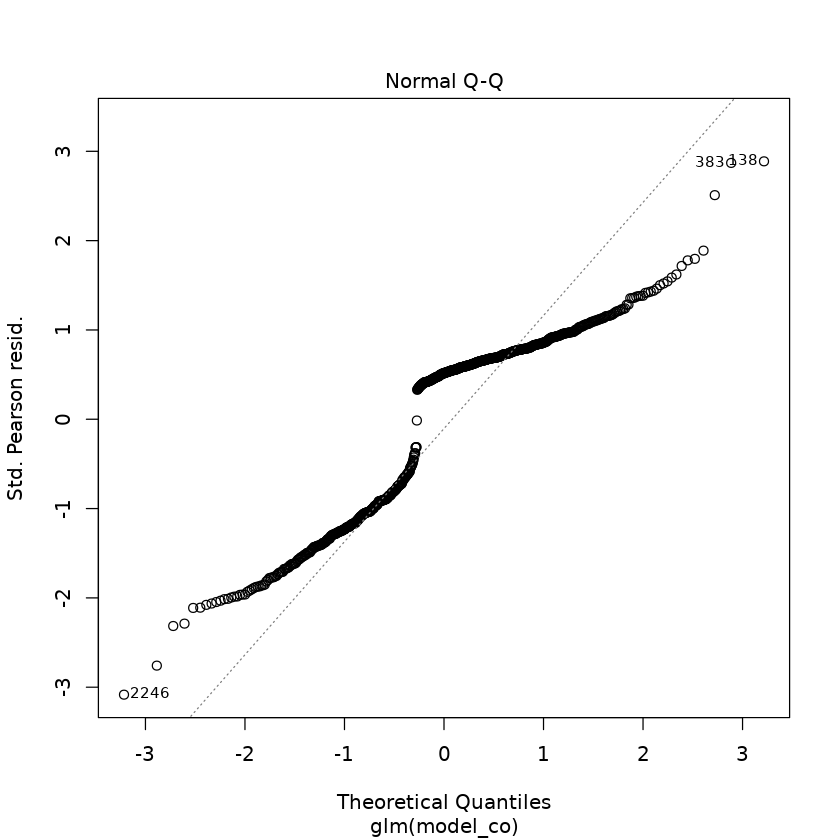

In [27]:
#logistic regression
model_co = "ratio_bin_vm13 ~ sex_baseline + age_baseline + height_baseline + vm1_baseline + vm3_baseline + vm4_baseline + vm5_baseline + vm13_baseline + vm15_baseline + ventilated_baseline + vis_baseline + bolus_rate + fluidamount100"
fit_co_log = glm(model_co, data=df_psm %>% filter (bolus==1), family=binomial(link='logit'))
summary(fit_co_log)
confint(fit_co_log)
plot(fit_co_log, c(1,2))

## sv model


Call:
lm(formula = model_sv, data = df_psm)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.132  -2.889  -0.407   2.703  44.705 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)   
(Intercept)          -3.0027198  5.6343833  -0.533  0.59416   
sex_baselineM         1.0411456  0.3734309   2.788  0.00537 **
age_baseline         -0.0210183  0.0131671  -1.596  0.11064   
height_baseline       0.0358801  0.0166707   2.152  0.03153 * 
vm1_baseline          0.0281450  0.0455409   0.618  0.53666   
vm3_baseline         -0.0043611  0.0206117  -0.212  0.83246   
vm4_baseline          0.0008460  0.0377327   0.022  0.98211   
vm5_baseline          0.0454900  0.0582185   0.781  0.43471   
vm13_baseline        -1.8408597  0.9590101  -1.920  0.05511 . 
vm15_baseline        -0.0949315  0.0441556  -2.150  0.03172 * 
sv_baseline           0.0477338  0.0915858   0.521  0.60231   
ventilated_baseline  -0.4213691  0.3630360  -1.161  0.24596   
vis_baseline          0.000

,2.5 %,97.5 %
(Intercept),-1.405483e+01,8.0493924705
sex_baselineM,3.086430e-01,1.7736482236
age_baseline,-4.684627e-02,0.0048096189
height_baseline,3.179798e-03,0.0685803576
vm1_baseline,-6.118566e-02,0.1174756291
vm3_baseline,-4.479191e-02,0.0360697177
vm4_baseline,-7.316853e-02,0.0748605593
vm5_baseline,-6.870832e-02,0.1596882297
vm13_baseline,-3.722004e+00,0.0402844745
vm15_baseline,-1.815449e-01,-0.0083182158


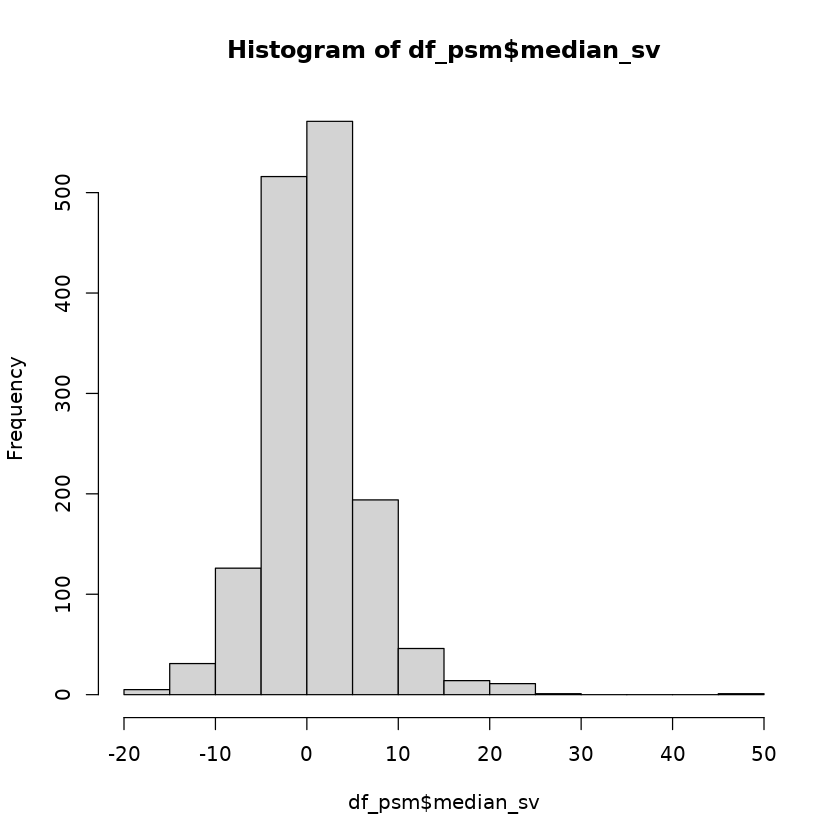

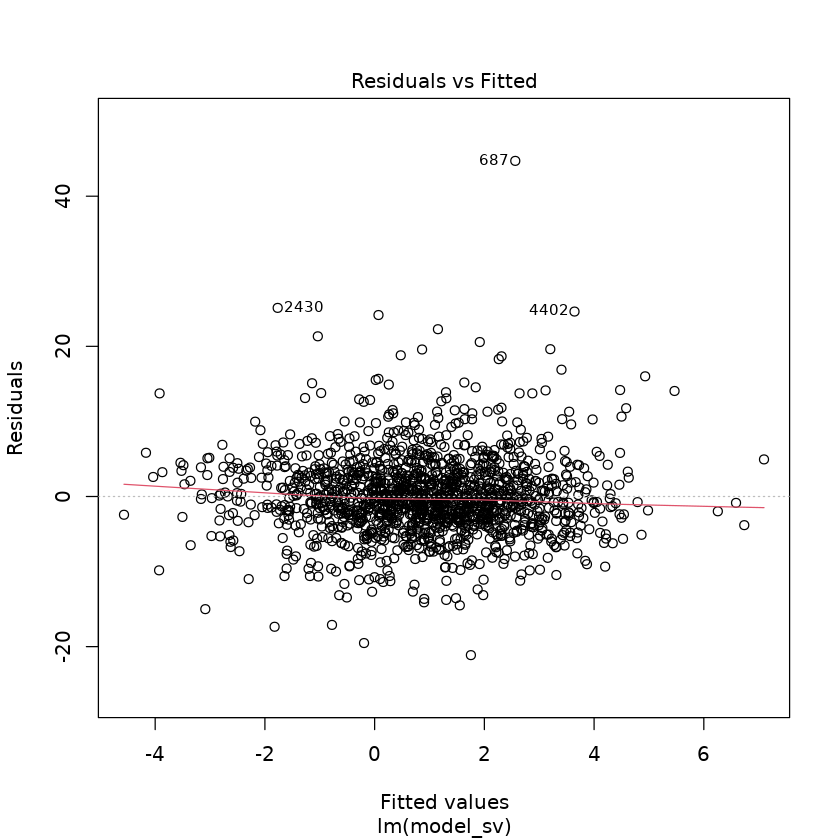

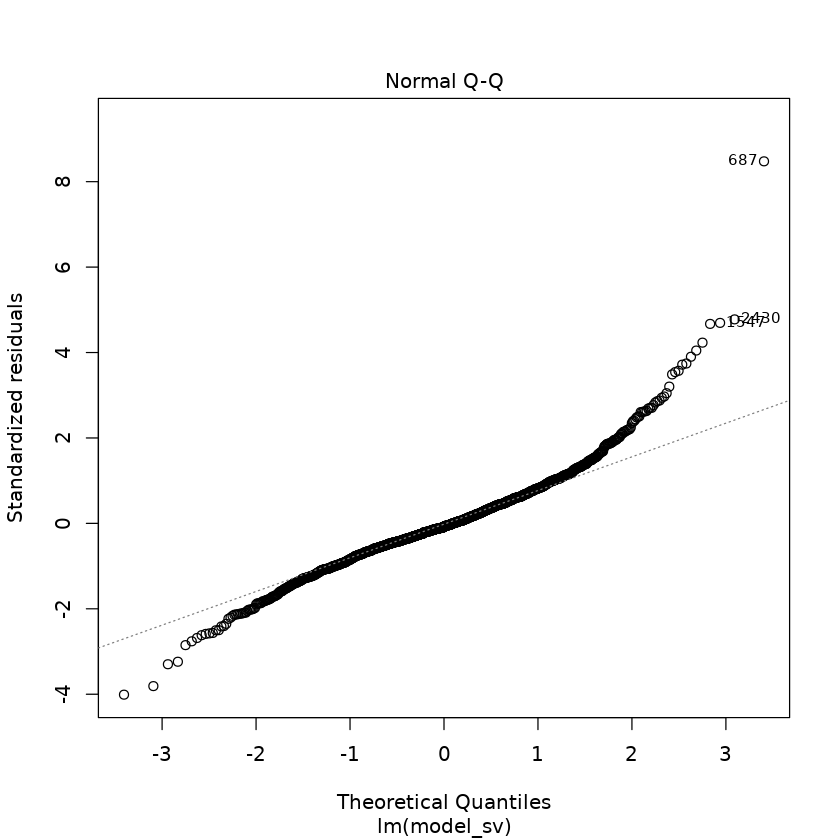

In [28]:
#sv model
model_sv = "median_sv ~ sex_baseline + age_baseline + height_baseline + vm1_baseline + vm3_baseline + vm4_baseline + vm5_baseline + vm13_baseline + vm15_baseline + sv_baseline + ventilated_baseline + vis_baseline + bolus_rate:bolus + fluidamount100:bolus"
fit_sv = lm(model_sv, data=df_psm)
summary(fit_sv)
confint(fit_sv)
hist(df_psm$median_sv)
plot(fit_sv, c(1,2))

In [29]:
# save models
save(fit_map, fit_co, fit_sv, file = "effect_models.Rdata")

# Supp Figure 3

In [10]:
load_single_variable <- function(variable, df_input) { 
    df_variable = df_input %>% select('patientid','bolusid','bolus',paste(variable, "baseline", sep="_"),contains(paste(variable, "_", sep="")))
    df_variable[,"baseline"] = df_variable[,paste(variable, "baseline", sep="_")]
    df_variable_long = gather(df_variable, condition, measurement, contains(paste(variable, "_", sep="")), factor_key=FALSE)
    df_variable_long = df_variable_long %>% separate(condition, c("variable", "timepoint"), "_")
    df_variable_long = df_variable_long %>% filter(timepoint !='trend' & timepoint != 'criterion')
    df_variable_long$uid <- with(df_variable_long, paste0(patientid, "_", bolusid))
    df_variable_long$timepoint <- gsub('baseline', '-300', df_variable_long$timepoint)
    df_variable_long$timepoint <- as.numeric(df_variable_long$timepoint)
    return (df_variable_long)
}

load_single_diff_variable <- function(variable, df_input) {
    for (column in grep(paste(variable, "_", sep=""), names(df_psm), value=TRUE)) {
        if (column != paste(variable, "baseline", sep="_"))
            df_input[column] <- df_input[column]-df_input[paste(variable, "baseline", sep="_")]
    }
    df_variable = df_input %>% select('patientid','bolusid','bolus',contains(paste(variable, "_", sep="")))
    df_variable_long = gather(df_variable, condition, measurement, 4:last_col(), factor_key=FALSE)
    df_variable_long = df_variable_long %>% separate(condition, c("variable", "timepoint"), "_")
    df_variable_long <- df_variable_long %>% filter(timepoint !='trend' & timepoint != 'criterion' & timepoint !='baseline')
    df_variable_long$uid <- with(df_variable_long, paste0(patientid, "_", bolusid))
    df_variable_long$timepoint <- as.numeric(df_variable_long$timepoint)
    return (df_variable_long)
}

plot_single_variable <- function(variable, df_variable_long) {  
    sum = df_variable_long %>%
        select(uid, timepoint, measurement, bolus) %>% #patient_id is the unique ID of the patient; moment_of_measurement is the moment of measurement; value is the value of the dependent variable; group is group
        group_by(timepoint, bolus) %>%
        summarise(mean_cl_normal(measurement))
    
    y_range_size = max(abs(sum[,3:5])) * 1.2
    if (y_range_size > 10)
        y_range_size = as.integer(y_range_size)
    else
        y_range_size = as.integer(y_range_size*10)/10
    count_y_pos = y_range_size/9
    p_y_pos = y_range_size * 0.92
    plot = df_variable_long %>%
        select(uid, timepoint, measurement, bolus) %>% #patient_id is the unique ID of the patient; moment_of_measurement is the moment of measurement; value is the value of the dependent variable; group is group
        group_by(timepoint, bolus) %>%
        summarise(mean_cl_normal(measurement), count = sum(!is.na(measurement))) %>%
        ggplot(aes(x = (timepoint/60) + 2.5, y = y, color = factor(bolus))) +
        geom_errorbar(aes(ymin = ymin, ymax = ymax), width = 0.5,  position = position_dodge(0.00), size = 0.5) +
        geom_point(size = 2) +
        geom_line(size = 0.5) +
        scale_color_manual(name = "", values = c("blue","red"), labels = c("Control","Bolus")) +
        ylab(VARIABLES_UNITS[variable]) +
        scale_x_continuous(expand = c(0.01, 0.01), limits=c(-5, 61)) +
        scale_y_continuous(limits=c(0, y_range_size), breaks = seq(0,y_range_size,y_range_size/10), expand=c(0,0)) +
        ggtitle(unlist(VARIABLES_CLEAR_NAMES[variable])) +
        geom_vline(xintercept=0, linetype="dashed", color = "darkgray", size=1.5) +
        geom_text(data = function(x) subset(x, bolus==1), aes(label = count, y = count_y_pos+y_range_size/30),  position=position_dodge(0.9), size = 3.5) +
        geom_text(data = function(x) subset(x, bolus==0), aes(label = count, y = count_y_pos),  position=position_dodge(0.9), size = 3.5) +
        theme(axis.text = element_text(color = "black", size = 14), axis.title = element_text(colour = "black", size = 15), panel.grid.major.y = element_line(colour = "gray"), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black"), legend.key=element_blank(), legend.background=element_blank(), legend.text=element_text(size=13), legend.position = c(0.20, 0.95), plot.title = element_text(hjust = 0.5, face="bold", size = 15)) +
        theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())  +              
        annotate(geom = "text", x = -2, y = count_y_pos+y_range_size/30*3.8, label = "Pre bolus", color = "darkgray", hjust = 0, angle = 90, size=5)+
        annotate(geom = "text", x = 2, y = count_y_pos+y_range_size/30*3.8, label = "Post bolus", color = "darkgray", hjust = 0, angle = 90, size=5)
    return (plot)
}
                  
plot_single_variable_diff <- function(variable, df_variable_long_diff) {  
    sum = df_variable_long_diff %>%
        select(uid, timepoint, measurement, bolus) %>% #patient_id is the unique ID of the patient; moment_of_measurement is the moment of measurement; value is the value of the dependent variable; group is group
        group_by(timepoint, bolus) %>%
        summarise(mean_cl_normal(measurement))
    print(sum)
    y_range_size = max(abs(sum[,3:5])) * 2
    y_range_size = as.integer(10*y_range_size)/10
    print(y_range_size)
    count_y_pos = -y_range_size/4*3
    plot = df_variable_long_diff %>%
        select(uid, timepoint, measurement, bolus) %>% #patient_id is the unique ID of the patient; moment_of_measurement is the moment of measurement; value is the value of the dependent variable; group is group
        group_by(timepoint, bolus) %>%
        summarise(mean_cl_normal(measurement), count = sum(!is.na(measurement))) %>%
        ggplot(aes(x = (timepoint/60) + 2.5, y = y, color = factor(bolus))) +
        geom_errorbar(aes(ymin = ymin, ymax = ymax), width = 0.5,  position = position_dodge(0.00), size = 0.5) +
        geom_point(size = 2) +
        geom_line(size = 0.5) +
        scale_color_manual(name = "", values = c("blue","red"), labels = c("Control","Bolus")) +
        xlab("Minutes after bolus end") +
        ylab(expression(Delta))+
        scale_x_continuous(expand = c(0.01, 0.01), limits=c(-5, 61)) +
        scale_y_continuous(limits=c(-y_range_size, y_range_size), breaks = seq(-y_range_size, y_range_size,y_range_size/2), expand=c(0,0)) +
        geom_text(data = function(x) subset(x, bolus==1), aes(label = count, y = count_y_pos+y_range_size/7),  position=position_dodge(0.9), size = 3.5) +
        geom_text(data = function(x) subset(x, bolus==0), aes(label = count, y = count_y_pos),  position=position_dodge(0.9), size = 3.5) +
        theme(legend.position = "none", panel.grid.major.y = element_line(colour = "gray"), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.title = element_text(colour = "black", size = 15), axis.text = element_text(color = "black", size = 14), legend.key=element_blank(), legend.background=element_blank(), legend.text=element_text(size=13), plot.title = element_text(hjust = 0.5, face="bold", size = 15))      
    return (plot)
}

In [11]:
df_variable_data <- load_single_variable("vm13", df_psm  %>% filter(ratio_bin_vm13))
df_variable_data_diff <- load_single_diff_variable("vm13", df_psm %>% filter(ratio_bin_vm13))

In [12]:
df_variable_data_diff

patientid,bolusid,bolus,variable,timepoint,measurement,uid
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
100125,2,1,vm13,0,0.15999994,100125_2
100125,4,0,vm13,0,0.12000000,100125_4
100246,3,0,vm13,0,-0.17916656,100246_3
100246,6,0,vm13,0,0.88750002,100246_6
100422,4,0,vm13,0,0.44666665,100422_4
100422,5,1,vm13,0,0.79285726,100422_5
100483,1,1,vm13,0,0.58666668,100483_1
100537,4,1,vm13,0,0.25333338,100537_4
100540,1,1,vm13,0,0.30666691,100540_1


In [13]:
p1 = plot_single_variable("vm13", df_variable_data)
p2 = plot_single_variable_diff("vm13", df_variable_data_diff)

`summarise()` regrouping output by 'timepoint' (override with `.groups` argument)

`summarise()` regrouping output by 'timepoint' (override with `.groups` argument)

`summarise()` regrouping output by 'timepoint' (override with `.groups` argument)



# A tibble: 24 x 5
# Groups:   timepoint [12]
   timepoint bolus     y  ymin  ymax
       <dbl> <dbl> <dbl> <dbl> <dbl>
 1         0     0 0.248 0.193 0.302
 2         0     1 0.194 0.142 0.246
 3       300     0 0.252 0.197 0.308
 4       300     1 0.255 0.202 0.308
 5       600     0 0.233 0.175 0.292
 6       600     1 0.368 0.313 0.423
 7       900     0 0.238 0.175 0.301
 8       900     1 0.429 0.374 0.485
 9      1200     0 0.255 0.192 0.318
10      1200     1 0.444 0.388 0.499
# … with 14 more rows
[1] 1


`summarise()` regrouping output by 'timepoint' (override with `.groups` argument)



In [14]:
png(paste0(OUTPUT_PATH, "/", paste0("supp_figure3.png")), height = 640, width = 540)   #pdf("path/to/file/PDFofG.pdf", height = 11, width = 8.5, paper = "letter")
ggarrange(p1, p2, ncol=1, nrow=2, heights=c(3,1))
dev.off()

png 
  2

In [10]:
#' @title Print regression models as HTML table
#' @name tab_model
#'
#' @description
#'   \code{tab_model()} creates HTML tables from regression models.
#'
#' @param title String, will be used as table caption.
#' @param terms Character vector with names of those terms (variables) that should
#'    be printed in the table. All other terms are removed from the output. If
#'    \code{NULL}, all terms are printed. Note that the term names must match
#'    the names of the model's coefficients. For factors, this means that
#'    the variable name is suffixed with the related factor level, and each
#'    category counts as one term. E.g. \code{rm.terms = "t_name [2,3]"}
#'    would remove the terms \code{"t_name2"} and \code{"t_name3"} (assuming
#'    that the variable \code{t_name} is categorical and has at least
#'    the factor levels \code{2} and \code{3}). Another example for the
#'    \emph{iris}-dataset: \code{terms = "Species"} would not work, instead
#'    use \code{terms = "Species [versicolor,virginica]"}.
#' @param rm.terms Character vector with names that indicate which terms should
#'    be removed from the output Counterpart to \code{terms}. \code{rm.terms =
#'    "t_name"} would remove the term \emph{t_name}. Default is \code{NULL}, i.e.
#'    all terms are used. For factors, levels that should be removed from the plot
#'    need to be explicitly indicated in square brackets, and match the model's
#'    coefficient names, e.g. \code{rm.terms = "t_name [2,3]"} would remove the terms
#'    \code{"t_name2"} and \code{"t_name3"} (assuming that the variable \code{t_name}
#'    was categorical and has at least the factor levels \code{2} and \code{3}).
#' @param keep,drop Character containing a regular expression pattern that
#'   describes the parameters that should be included (for \code{keep}) or excluded
#'   (for \code{drop}) in the returned data frame. \code{keep} may also be a
#'   named list of regular expressions. All non-matching parameters will be
#'   removed from the output. If \code{keep} has more than one element, these
#'   will be merged with an \code{OR} operator into a regular expression pattern
#'   like this: \code{"(one|two|three)"}. See further details in
#'   \code{?parameters::model_parameters}.
#' @param pred.labels Character vector with labels of predictor variables.
#'    If not \code{NULL}, \code{pred.labels} will be used in the first
#'    table column with the predictors' names. By default, if \code{auto.label = TRUE}
#'    and \href{https://strengejacke.github.io/sjlabelled/articles/intro_sjlabelled.html}{data is labelled},
#'    \code{\link[sjlabelled]{term_labels}} is called to retrieve the labels
#'    of the coefficients, which will be used as predictor labels. If data is
#'    not labelled, \href{https://easystats.github.io/parameters/reference/format_parameters.html}{format_parameters()}
#'    is used to create pretty labels. If \code{pred.labels = ""} or \code{auto.label = FALSE}, the raw
#'    variable names as used in the model formula are used as predictor
#'    labels. If \code{pred.labels} is a named vector, predictor labels (by
#'    default, the names of the model's coefficients) will be matched with the
#'    names of \code{pred.labels}. This ensures that labels always match the
#'    related predictor in the table, no matter in which way the predictors
#'    are sorted. See 'Examples'.
#' @param dv.labels Character vector with labels of dependent variables of all
#'    fitted models. If \code{dv.labels = ""}, the row with names of dependent
#'    variables is omitted from the table.
#' @param show.intercept Logical, if \code{TRUE}, the intercepts are printed.
#' @param show.est Logical, if \code{TRUE}, the estimates are printed.
#' @param show.zeroinf Logical, if \code{TRUE} and model has a zero-inflated
#'    model part, this is also printed to the table.
#' @param show.re.var Logical, if \code{TRUE}, prints the random effect variances
#'    for mixed models. See \code{\link[insight]{get_variance}} for details.
#' @param show.icc Logical, if \code{TRUE}, prints the intraclass correlation
#'    coefficient for mixed models. See \code{\link[performance]{icc}} for details.
#' @param show.ngroups Logical, if \code{TRUE}, shows number of random effects groups
#'    for mixed models.
#' @param show.dev Logical, if \code{TRUE}, shows the deviance of the model.
#' @param show.loglik Logical, if \code{TRUE}, shows the log-Likelihood of the model.
#' @param show.ci Either logical, and if \code{TRUE}, the confidence intervals
#'    is printed to the table; if \code{FALSE}, confidence intervals are
#'    omitted. Or numeric, between 0 and 1, indicating the range of the
#'    confidence intervals.
#' @param show.std Indicates whether standardized beta-coefficients should
#'    also printed, and if yes, which type of standardization is done.
#'    See 'Details'.
#' @param show.p Logical, if \code{TRUE}, p-values are also printed.
#' @param show.se Logical, if \code{TRUE}, the standard errors are
#'   also printed. If robust standard errors are required, use arguments
#'   \code{vcov.fun}, \code{vcov.type} and \code{vcov.args} (see
#'   \code{\link[parameters]{standard_error_robust}} and
#'   \href{https://easystats.github.io/parameters/articles/model_parameters_robust.html}{this vignette}
#'   for details).
#' @param show.r2 Logical, if \code{TRUE}, the r-squared value is also printed.
#'    Depending on the model, these might be pseudo-r-squared values, or Bayesian
#'    r-squared etc. See \code{\link[performance]{r2}} for details.
#' @param show.stat Logical, if \code{TRUE}, the coefficients' test statistic
#'    is also printed.
#' @param show.df Logical, if \code{TRUE} and \code{p.val = "kr"}, the p-values
#'    for linear mixed models are based on df with Kenward-Rogers approximation.
#'    These df-values are printed. See \code{\link[parameters]{p_value}} for details.
#' @param string.pred Character vector,used as headline for the predictor column.
#'    Default is \code{"Predictors"}.
#' @param string.est Character vector, used for the column heading of coefficients.
#'    Default is based on the response scale, e.g. for logistic regression models,
#'    \code{"Odds Ratios"} will be chosen, while for Poisson models it is
#'    \code{"Incidence Rate Ratios"} etc. Default if not specified is \code{"Estimate"}.
#' @param string.std Character vector, used for the column heading of standardized beta coefficients. Default is \code{"std. Beta"}.
#' @param string.ci Character vector, used for the column heading of confidence interval values. Default is \code{"CI"}.
#' @param string.se Character vector, used for the column heading of standard error values. Default is \code{"std. Error"}.
#' @param string.std_se Character vector, used for the column heading of standard error of standardized coefficients. Default is \code{"standardized std. Error"}.
#' @param string.std_ci Character vector, used for the column heading of confidence intervals of standardized coefficients. Default is \code{"standardized std. Error"}.
#' @param string.p Character vector, used for the column heading of p values. Default is \code{"p"}.
#' @param string.std.p Character vector, used for the column heading of p values. Default is \code{"std. p"}.
#' @param string.df Character vector, used for the column heading of degrees of freedom. Default is \code{"df"}.
#' @param string.stat Character vector, used for the test statistic. Default is \code{"Statistic"}.
#' @param string.std.stat Character vector, used for the test statistic. Default is \code{"std. Statistic"}.
#' @param string.resp Character vector, used for the column heading of of the response level for multinominal or categorical models. Default is \code{"Response"}.
#' @param string.intercept Character vector, used as name for the intercept parameter. Default is \code{"(Intercept)"}.
#' @param strings Named character vector, as alternative to arguments like \code{string.ci}
#'    or \code{string.p} etc. The name (lhs) must be one of the string-indicator from
#'    the aforementioned arguments, while the value (rhs) is the string that is used
#'    as column heading. E.g., \code{strings = c(ci = "Conf.Int.", se = "std. Err")}
#'    would be equivalent to setting \code{string.ci = "Conf.Int.", string.se = "std. Err"}.
#' @param ci.hyphen Character vector, indicating the hyphen for confidence interval range.
#'    May be an HTML entity. See 'Examples'.
#' @param minus.sign string, indicating the minus sign for negative numbers.
#'    May be an HTML entity. See 'Examples'.
#' @param emph.p Logical, if \code{TRUE}, significant p-values are shown bold faced.
#' @param digits Amount of decimals for estimates
#' @param digits.p Amount of decimals for p-values
#' @param digits.rsq Amount of decimals for r-squared values
#' @param digits.re Amount of decimals for random effects part of the summary table.
#' @param collapse.ci Logical, if \code{FALSE}, the CI values are shown in
#'    a separate table column.
#' @param collapse.se Logical, if \code{FALSE}, the SE values are shown in
#'    a separate table column.
#' @param linebreak Logical, if \code{TRUE} and \code{collapse.ci = FALSE} or
#'    \code{collapse.se = FALSE}, inserts a line break between estimate and
#'    CI resp. SE values. If \code{FALSE}, values are printed in the same line
#'    as estimate values.
#' @param show.reflvl Logical, if \code{TRUE}, an additional row is inserted to
#'    the table before each predictor of type \code{\link{factor}}, which will
#'    indicate the reference level of the related factor.
#' @param show.ci50 Logical, if \code{TRUE}, for Bayesian models, a second
#'    credible interval is added to the table output.
#' @param bootstrap Logical, if \code{TRUE}, returns bootstrapped estimates..
#' @param iterations Numeric, number of bootstrap iterations (default is 1000).
#' @param seed Numeric, the number of the seed to replicate bootstrapped estimates. If \code{NULL}, uses random seed.
#' @param show.fstat Logical, if \code{TRUE}, the F-statistics for each model is
#'    printed in the table summary. This option is not supported by all model types.
#' @param show.aic Logical, if \code{TRUE}, the AIC value for each model is printed
#'    in the table summary.
#' @param show.aicc Logical, if \code{TRUE}, the second-order AIC value for each model
#'    is printed in the table summary.
#' @param show.obs Logical, if \code{TRUE}, the number of observations per model is
#'    printed in the table summary.
#' @param col.order Character vector, indicating which columns should be printed
#'    and in which order. Column names that are excluded from \code{col.order}
#'    are not shown in the table output. However, column names that are included,
#'    are only shown in the table when the related argument (like \code{show.est}
#'    for \code{"estimate"}) is set to \code{TRUE} or another valid value.
#'    Table columns are printed in the order as they appear in \code{col.order}.
#' @param df.method,p.val Method for computing degrees of freedom for p-values,
#'   standard errors and confidence intervals (CI). Only applies to mixed models.
#'   Use \code{df.method = "wald"} for a faster, but less precise computation.
#'   This will use the residual degrees of freedom (as returned by \code{df.residual()})
#'   for linear mixed models, and \code{Inf} degrees if freedom for all other
#'   model families. \code{df.method = "kenward"} (or \code{df.method = "kr"})
#'   uses Kenward-Roger approximation for the degrees of freedom.
#'   \code{df.method = "satterthwaite"} uses Satterthwaite's approximation and
#'   \code{"ml1"} uses a "m-l-1" heuristic see \code{\link[parameters]{degrees_of_freedom}}
#'   for details). Use \code{show.df = TRUE} to show the approximated degrees of freedom
#'   for each coefficient.
#' @param p.style Character, indicating if p-values should be printed as
#'   numeric value (\code{"numeric"}), as 'stars' (asterisks) only (\code{"stars"}),
#'   or scientific (\code{"scientific"}). Scientific and numeric style can be
#'   combined with "stars", e.g. \code{"numeric_stars"}
#' @param CSS A \code{\link{list}} with user-defined style-sheet-definitions,
#'    according to the \href{http://www.w3.org/Style/CSS/}{official CSS syntax}.
#'    See 'Details' or \href{https://strengejacke.github.io/sjPlot/articles/table_css.html}{this package-vignette}.
#' @param file Destination file, if the output should be saved as file.
#'    If \code{NULL} (default), the output will be saved as temporary file and
#'    opened either in the IDE's viewer pane or the default web browser.
#' @param use.viewer Logical, if \code{TRUE}, the HTML table is shown in the IDE's
#'    viewer pane. If \code{FALSE} or no viewer available, the HTML table is
#'    opened in a web browser.
#'
#' @inheritParams plot_models
#' @inheritParams plot_model
#' @inheritParams tab_df
#'
#' @return Invisibly returns
#'          \itemize{
#'            \item the web page style sheet (\code{page.style}),
#'            \item the web page content (\code{page.content}),
#'            \item the complete html-output (\code{page.complete}) and
#'            \item the html-table with inline-css for use with knitr (\code{knitr})
#'            }
#'            for further use.
#'
#' @note The HTML tables can either be saved as file and manually opened (use argument \code{file}) or
#'         they can be saved as temporary files and will be displayed in the RStudio Viewer pane (if working with RStudio)
#'         or opened with the default web browser. Displaying resp. opening a temporary file is the
#'         default behaviour (i.e. \code{file = NULL}).
#'         \cr \cr
#'         Examples are shown in these three vignettes:
#'         \href{https://strengejacke.github.io/sjPlot/articles/tab_model_estimates.html}{Summary of Regression Models as HTML Table},
#'         \href{https://strengejacke.github.io/sjPlot/articles/tab_mixed.html}{Summary of Mixed Models as HTML Table} and
#'         \href{https://strengejacke.github.io/sjPlot/articles/tab_bayes.html}{Summary of Bayesian Models as HTML Table}.
#'
#' @details
#' \subsection{Standardized Estimates}{
#'   Default standardization is done by completely refitting the model on the
#'   standardized data. Hence, this approach is equal to standardizing the
#'   variables before fitting the model, which is particularly recommended for
#'   complex models that include interactions or transformations (e.g., polynomial
#'   or spline terms). When \code{show.std = "std2"}, standardization of estimates
#'   follows \href{http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf}{Gelman's (2008)}
#'   suggestion, rescaling the estimates by dividing them by two standard deviations
#'   instead of just one. Resulting coefficients are then directly comparable for
#'   untransformed binary predictors. For backward compatibility reasons,
#'   \code{show.std} also may be a logical value; if \code{TRUE}, normal standardized
#'   estimates are printed (same effect as \code{show.std = "std"}). Use
#'   \code{show.std = NULL} (default) or \code{show.std = FALSE}, if no standardization
#'   is required.
#' }
#' \subsection{How do I use \code{CSS}-argument?}{
#'    With the \code{CSS}-argument, the visual appearance of the tables
#'    can be modified. To get an overview of all style-sheet-classnames
#'    that are used in this function, see return value \code{page.style} for details.
#'    Arguments for this list have following syntax:
#'    \enumerate{
#'      \item the class-names with \code{"css."}-prefix as argument name and
#'      \item each style-definition must end with a semicolon
#'    }
#'    You can add style information to the default styles by using a + (plus-sign) as
#'    initial character for the argument attributes. Examples:
#'    \itemize{
#'      \item \code{css.table = 'border:2px solid red;'} for a solid 2-pixel table border in red.
#'      \item \code{css.summary = 'font-weight:bold;'} for a bold fontweight in the summary row.
#'      \item \code{css.lasttablerow = 'border-bottom: 1px dotted blue;'} for a blue dotted border of the last table row.
#'      \item \code{css.colnames = '+color:green'} to add green color formatting to column names.
#'      \item \code{css.arc = 'color:blue;'} for a blue text color each 2nd row.
#'      \item \code{css.caption = '+color:red;'} to add red font-color to the default table caption style.
#'    }
#' }
#
#' @importFrom dplyr full_join select if_else mutate
#' @importFrom purrr reduce map2 map_if map_df compact map_lgl map_chr flatten_chr
#' @importFrom sjlabelled response_labels term_labels
#' @importFrom sjmisc word_wrap var_rename add_columns add_case
#' @importFrom insight model_info is_multivariate find_random get_data find_predictors
#' @importFrom performance r2 variance_decomposition
#' @importFrom stats nobs setNames
#' @importFrom rlang .data
#' @importFrom utils packageVersion
#' @export
tab_model <- function(
  ...,
  transform,

  show.intercept = TRUE,
  show.est = TRUE,
  show.ci = .95,
  show.ci50 = FALSE,
  show.se = NULL,
  show.std = NULL,
  show.p = TRUE,
  show.stat = FALSE,
  show.df = FALSE,

  show.zeroinf = TRUE,
  show.r2 = TRUE,
  show.icc = TRUE,
  show.re.var = TRUE,
  show.ngroups = TRUE,
  show.fstat = FALSE,
  show.aic = FALSE,
  show.aicc = FALSE,
  show.dev = FALSE,
  show.loglik = FALSE,
  show.obs = TRUE,
  show.reflvl = FALSE,

  terms = NULL,
  rm.terms = NULL,
  order.terms = NULL,
  keep = NULL,
  drop = NULL,

  title = NULL,
  pred.labels = NULL,
  dv.labels = NULL,
  wrap.labels = 25,

  bootstrap = FALSE,
  iterations = 1000,
  seed = NULL,

  robust = FALSE,
  vcov.fun = NULL,
  vcov.type = c("HC3", "const", "HC", "HC0", "HC1", "HC2", "HC4", "HC4m", "HC5", "CR0", "CR1", "CR1p", "CR1S", "CR2", "CR3"),
  vcov.args = NULL,

  string.pred = "Predictors",
  string.est = "Estimate",
  string.std = "std. Beta",
  string.ci = "CI",
  string.se = "std. Error",
  string.std_se = "standardized std. Error",
  string.std_ci = "standardized CI",
  string.p = "p",
  string.std.p = "std. p",
  string.df = "df",
  string.stat = "Statistic",
  string.std.stat = "std. Statistic",
  string.resp = "Response",
  string.intercept = "(Intercept)",
  strings = NULL,
  ci.hyphen = "&nbsp;&ndash;&nbsp;",
  minus.sign = "&#45;",

  collapse.ci = FALSE,
  collapse.se = FALSE,
  linebreak = TRUE,


  col.order = c(
    "est",
    "se",
    "std.est",
    "std.se",
    "ci",
    "std.ci",
    "ci.inner",
    "ci.outer",
    "stat",
    "std.stat",
    "p",
    "std.p",
    "df.error",
    "response.level"
  ),

  digits = 2,
  digits.p = 3,
  digits.rsq = 3,
  digits.re = 2,
  emph.p = TRUE,
  p.val = NULL,
  df.method = NULL,
  p.style = c("numeric", "stars", "numeric_stars", "scientific", "scientific_stars"),
  p.threshold = c(0.05, 0.01, 0.001),
  p.adjust = NULL,

  case = "parsed",
  auto.label = TRUE,
  prefix.labels = c("none", "varname", "label"),
  bpe = "median",
  CSS = css_theme("regression"),
  file = NULL,
  use.viewer = TRUE,
  encoding = "UTF-8"
) {

  if (!missing(df.method)) {
    p.val <- df.method
  }

  if (!is.null(p.val)) {
    p.val <- match.arg(p.val, choices = c("wald", "profile", "kenward", "kr", "satterthwaite", "ml1", "betwithin"))
  }
  p.style <- match.arg(p.style)
  prefix.labels <- match.arg(prefix.labels)
  vcov.type <- match.arg(vcov.type)

  change_string_est <- !missing(string.est)

  # if we prefix labels, use different default for case conversion,
  # else the separating white spaces after colon are removed.
  if (missing(case)) {
    if (prefix.labels == "none" && !show.reflvl)
      case <- "parsed"
    else
      case <- NULL
  }

  if (p.style == "stars") show.p <- FALSE

  # default robust?
  if (isTRUE(robust)) {
    vcov.type <- "HC3"
    vcov.fun <- "vcovHC"
  }

  # check se-argument
  vcov.fun <- check_se_argument(se = vcov.fun, type = NULL)


  models <- list(...)

  if (length(class(models[[1]])) == 1 && class(models[[1]]) == "list")
    models <- lapply(models[[1]], function(x) x)

  names(models) <- unlist(lapply(
    match.call(expand.dots = F)$`...`,
    function(.x) deparse(.x, width.cutoff = 500L))
  )

  auto.transform <- missing(transform)
  ci.lvl <- ifelse(is.null(show.ci), .95, show.ci)

  copos <- which("est" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "estimate"

  copos <- which("se" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.error"

  copos <- which("ci" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "conf.int"

  copos <- which("std.est" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.estimate"

  copos <- which("std.se" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.se"

  copos <- which("std.ci" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.conf.int"

  copos <- which("p" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "p.value"

  copos <- which("std.p" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.p.value"

  copos <- which("stat" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "statistic"

  copos <- which("std.stat" == col.order)
  if (!sjmisc::is_empty(copos)) col.order[copos] <- "std.statistic"

  # match strings, to label the default strings in the table,
  # like "Estimate", "CI" etc.
  if (!sjmisc::is_empty(strings) && !is.null(names(strings))) {
    s.names <- names(strings)
    if ("pred" %in% s.names) string.pred <- strings[["pred"]]
    if ("est" %in% s.names) string.est <- strings[["est"]]
    if ("std" %in% s.names) string.std <- strings[["std"]]
    if ("ci" %in% s.names) string.ci <- strings[["ci"]]
    if ("se" %in% s.names) string.se <- strings[["se"]]
    if ("std_se" %in% s.names) string.std_se <- strings[["std_se"]]
    if ("std_ci" %in% s.names) string.std_ci <- strings[["std_ci"]]
    if ("p" %in% s.names) string.p <- strings[["p"]]
    if ("std.p" %in% s.names) string.std.p <- strings[["std.p"]]
    if ("df" %in% s.names) string.df <- strings[["df"]]
    if ("stat" %in% s.names) string.stat <- strings[["stat"]]
    if ("std.stat" %in% s.names) string.std.stat <- strings[["std.stat"]]
    if ("resp" %in% s.names) string.resp <- strings[["resp"]]
    if ("intercept" %in% s.names) string.intercept <- strings[["intercept"]]
  }

  model.list <- purrr::map2(
    models,
    1:length(models),
    function(model, i) {

      # get info on model family
      fam.info <- insight::model_info(model)

      if (insight::is_multivariate(model))
        fam.info <- fam.info[[1]]

      # check whether estimates should be transformed or not

      if (auto.transform) {
        if (fam.info$is_linear || identical(fam.info$link_function, "identity"))
          transform <- NULL
        else
          transform <- "exp"
      }

      # get tidy output of summary ----

      dat <- tidy_model(
        model = model,
        ci.lvl = ci.lvl,
        tf = transform,
        type = "est",
        bpe = bpe,
        robust = list(vcov.fun = vcov.fun, vcov.type = vcov.type, vcov.args = vcov.args),
        facets = FALSE,
        show.zeroinf = show.zeroinf,
        p.val = p.val,
        bootstrap = bootstrap,
        iterations = iterations,
        seed = seed,
        p_adjust = p.adjust,
        keep = keep,
        drop = drop
      )


      # transform estimates

      if (!is.stan(model) && !is.null(transform)) {
        funtrans <- match.fun(transform)
        dat[["estimate"]] <- funtrans(dat[["estimate"]])
        dat[["conf.low"]] <- funtrans(dat[["conf.low"]])
        dat[["conf.high"]] <- funtrans(dat[["conf.high"]])
        dat[["std.error"]] <- dat[["std.error"]] * dat[["estimate"]]
      }


      # merge CI columns

      dat <- dat %>%
        dplyr::mutate(conf.int = sprintf(
          "%.*f%s%.*f",
          digits,
          .data$conf.low,
          ci.hyphen,
          digits,
          .data$conf.high
        )) %>%
        dplyr::select(-.data$conf.low, -.data$conf.high)

      # get inner probability (i.e. 2nd CI for Stan-models) ----

      if (is.stan(model)) {
        dat <- dat %>%
          sjmisc::var_rename(conf.int = "ci.outer") %>%
          dplyr::mutate(ci.inner = sprintf(
            "%.*f%s%.*f",
            digits,
            .data$conf.low50,
            ci.hyphen,
            digits,
            .data$conf.high50
          )) %>%
            dplyr::select(-.data$conf.low50, -.data$conf.high50)
      }

      # tidy output of standardized values ----

      if (!is.null(show.std) && !is.stan(model)) {
        std_method <- switch(show.std, "std" = "refit", "std2" = "2sd", "")
        tmp_dat <- tidy_model(
          model = model,
          ci.lvl = ci.lvl,
          tf = transform,
          type = "est",
          bpe = bpe,
          robust = list(vcov.fun = vcov.fun, vcov.type = vcov.type, vcov.args = vcov.args),
          facets = FALSE,
          show.zeroinf = show.zeroinf,
          p.val = p.val,
          p_adjust = p.adjust,
          standardize = std_method,
          bootstrap = bootstrap,
          iterations = iterations,
          seed = seed,
          keep = keep,
          drop = drop
        ) %>%
          format_p_values(p.style, digits.p, emph.p, p.threshold) %>%
          sjmisc::var_rename(
            estimate = "std.estimate",
            std.error = "std.se",
            conf.low = "std.conf.low",
            conf.high = "std.conf.high",
            p.value = "std.p.value",
            statistic = "std.statistic",
            p.stars = "std.p.stars"
          ) %>%
          dplyr::select(-1)

        # transform estimates

        if (!is.stan(model) && !is.null(transform)) {
          funtrans <- match.fun(transform)
          tmp_dat[["std.estimate"]] <- funtrans(tmp_dat[["std.estimate"]])
          tmp_dat[["std.conf.low"]] <- funtrans(tmp_dat[["std.conf.low"]])
          tmp_dat[["std.conf.high"]] <- funtrans(tmp_dat[["std.conf.high"]])
          tmp_dat[["std.se"]] <- tmp_dat[["std.se"]] * tmp_dat[["std.estimate"]]
        }

        dat <- tmp_dat %>%
          sjmisc::add_columns(dat) %>%
          dplyr::mutate(std.conf.int = sprintf(
            "%.*f%s%.*f",
            digits,
            .data$std.conf.low,
            ci.hyphen,
            digits,
            .data$std.conf.high
          )) %>%
          dplyr::select(-.data$std.conf.low, -.data$std.conf.high)
        # if t-statistic is the same for standardized and unstandardized model
        # remove standardized; ignore intercept
        if (all(round(dat$statistic[-1], 3) == round(dat$std.statistic[-1], 3))) {
          dat <- dat %>%
            dplyr::select(-.data$std.statistic, -.data$std.p.value)
        }
      }

      # format p values for unstandardized model
      dat <- format_p_values(dat, p.style, digits.p, emph.p, p.threshold)

      # add asterisks to estimates ----

      if (grepl("stars", p.style)) {
        if (obj_has_name(dat, "estimate"))
          dat$estimate <- sprintf("%.*f <sup>%s</sup>", digits, dat$estimate, dat$p.stars)
        if (!show.est && obj_has_name(dat, "std.estimate")) {
          dat$std.estimate <- sprintf("%.*f <sup>%s</sup>", digits, dat$std.estimate, dat$std.p.stars)
          dat <- dplyr::select(dat, -.data$std.p.stars)
        }
      }

      dat <- dplyr::select(dat, -.data$p.stars)


      # switch column for p-value and conf. int. ----

      dat <- dat[, sort_columns(colnames(dat), is.stan(model), col.order)]


      # add suffix to column names, so we can distinguish models later

      cn <- colnames(dat)[2:ncol(dat)]
      colnames(dat)[2:ncol(dat)] <- sprintf("%s_%i", cn, i)


      # for HTML, convert numerics to character ----

      dat <- dat %>%
        purrr::map_if(is.numeric, ~ sprintf("%.*f", digits, .x)) %>%
        as.data.frame(stringsAsFactors = FALSE)


      # remove 2nd HDI if requested ----

      if (!show.ci50)
        dat <- dplyr::select(dat, -string_starts_with("ci.inner", colnames(dat)))


      ## TODO optionally insert linebreak for new-line-CI / SE

      # merge estimates and CI / SE columns, if requested ----

      if (collapse.ci) {

        if (linebreak)
          lb <- "<br>"
        else
          lb <- " "

        est.cols <- string_starts_with("estimate", x = colnames(dat))
        dat[[est.cols]] <- sprintf("%s%s(%s)", dat[[est.cols]], lb, dat[[est.cols + 2]])

        # for stan models, we also have 50% HDI
        if (!sjmisc::is_empty(string_starts_with("ci", x = colnames(dat)))) {
          if (isTRUE(show.ci50)) {
            dat <- dplyr::select(dat, -string_starts_with("ci.inner", x = colnames(dat)))
            dat[[est.cols]] <- sprintf("%s%s(%s)", dat[[est.cols]], lb, dat[[est.cols + 2]])
          }
          dat <- dplyr::select(dat, -string_starts_with("ci.outer", x = colnames(dat)))
        } else {
          dat <- dplyr::select(dat, -string_starts_with("conf.int", x = colnames(dat)))
        }

        std.cols <- string_starts_with("std.estimate", x = colnames(dat))
        if (!sjmisc::is_empty(std.cols)) {
          dat[[std.cols]] <- sprintf("%s%s(%s)", dat[[std.cols]], lb, dat[[std.cols + 2]])
          dat <- dplyr::select(dat, -string_starts_with("std.conf.int", x = colnames(dat)))
        }
      }

      if (collapse.se) {

        if (linebreak)
          lb <- "<br>"
        else
          lb <- " "

        est.cols <- string_starts_with("estimate", x = colnames(dat))
        dat[[est.cols]] <- sprintf("%s%s(%s)", dat[[est.cols]], lb, dat[[est.cols + 1]])
        dat <- dplyr::select(dat, -string_starts_with("std.error", x = colnames(dat)))

        std.cols <- string_starts_with("std.estimate", x = colnames(dat))
        if (!sjmisc::is_empty(std.cols)) {
          dat[[std.cols]] <- sprintf("%s%s(%s)", dat[[std.cols]], lb, dat[[std.cols + 1]])
          dat <- dplyr::select(dat, -string_starts_with("std.se", x = colnames(dat)))
        }
      }


      # replace minus signs
      dat[] <- lapply(dat, function(i) gsub("-(\\d)(.*)", paste0(minus.sign, "\\1\\2"), i))


      # handle zero-inflation part ----

      zidat <- NULL
      wf <- string_starts_with("wrap.facet", x = colnames(dat))

      if (!sjmisc::is_empty(wf)) {
        zi <- which(dat[[wf]] %in% c("Zero-Inflated Model", "Zero Inflation Model", "zero_inflated", "zi"))

        if (show.zeroinf && !sjmisc::is_empty(zi)) {
          zidat <- dat %>%
            dplyr::slice(!! zi) %>%
            dplyr::select(!! -wf)
        }

        if (!sjmisc::is_empty(zi)) dat <- dplyr::slice(dat, !! -zi)
        dat <- dplyr::select(dat, !! -wf)
      }


      # Add no of observations statistic ----

      n_obs <- NULL

      if (show.obs) {
        n_obs <- get_observations(model)
      }


      vars <- vars_brms <- NULL

      # extract variance components ----

      if ((show.icc || show.re.var || show.r2) && is_mixed_model(model)) {
        if (inherits(model, "brmsfit")) {
          vars <- suppressWarnings(insight::get_variance(model))
          if (is.null(vars)) {
            vars_brms <- tryCatch(
              {
                performance::variance_decomposition(model)
              },
              error = function(e) {
                NULL
              }
            )
            if (!is.null(vars_brms)) {
              vars$var.intercept <- attr(vars_brms, "var_rand_intercept")
              vars$var.residual <- attr(vars_brms, "var_residual")
            }
          }
        } else {
          vars <- suppressWarnings(insight::get_variance(model))
        }
      } else {
        vars <- NULL
      }

      # sanity check for models currently not supported by "get_variance()"
      if (!is.null(vars) && length(vars) == 1 && is.na(vars)) vars <- NULL

      # Add ICC statistic ----

      icc <- NULL

      if (show.icc && is_mixed_model(model) && !is.null(vars) && !all(is.na(vars))) {
        if (inherits(model, "brmsfit") && !is.null(vars_brms)) {
          icc <- list(icc.adjusted = vars_brms$ICC_decomposed)
        } else {
          icc <- list(icc.adjusted = vars$var.random / (vars$var.random + vars$var.residual))
        }
      }

      # Add r-squared statistic ----

      rsq <- NULL

      if (show.r2 && !insight::is_multivariate(model)) {
        # if marginal and conditional r-squared already have been computed
        # via adjusted ICC, use these results and avoid time consuming
        # multiple computation
        if (is_mixed_model(model)) {
          if (inherits(model, "brmsfit")) {
            rsqdummy <- tryCatch(
              {
                suppressWarnings(performance::r2(model))
              },
              error = function(x) { NULL }
            )
            if (!is.null(rsqdummy)) {
              rsq <- list(
                `Marginal R2` = rsqdummy$R2_Bayes_marginal,
                `Conditional R2` = rsqdummy$R2_Bayes
              )
            }
          } else if (!is.null(vars)) {
            if (is.null(vars$var.random)) {
              rsq <- list(
                `Marginal R2` = vars$var.fixed / (vars$var.fixed + vars$var.residual),
                `Conditional R2` = NA
              )
            } else {
              rsq <- list(
                `Marginal R2` = vars$var.fixed / (vars$var.fixed + vars$var.random + vars$var.residual),
                `Conditional R2` = (vars$var.fixed + vars$var.random) / (vars$var.fixed + vars$var.random + vars$var.residual)
              )
            }
          }
        } else {
          rsq <- tryCatch(
            {
              suppressWarnings(performance::r2(model))
            },
            error = function(x) { NULL }
          )

          # fix names of r-squared values

          if (!is.null(rsq)) {
            rnames <- sub("_", " ", names(rsq))
            names(rsq) <- rnames
          }
        }
      }


      # Add number of random effect groups ----

      n_re_grps <- NULL

      if (show.ngroups && is_mixed_model(model)) {
        rand_eff <- insight::get_data(model)[, insight::find_random(model, split_nested = TRUE, flatten = TRUE), drop = FALSE]
        n_re_grps <- sapply(rand_eff, function(.i) length(unique(.i, na.rm = TRUE)))
        names(n_re_grps) <- sprintf("ngrps.%s", names(n_re_grps))
      }


      # Add deviance and AIC statistic ----

      dev <- NULL
      if (show.dev) dev <- model_deviance(model)

      aic <- NULL
      if (show.aic) aic <- model_aic(model)

      aicc <- NULL
      if (show.aicc) aicc <- model_aicc(model)

      loglik <- NULL
      if (show.loglik) loglik <- model_loglik(model)


      ## TODO add F-Statistic


      # fix brms coefficient names

      if (inherits(model, "brmsfit")) {
        dat$term <- gsub("^b_", "", dat$term)
        if (!is.null(zidat)) zidat$term <- gsub("^b_", "", zidat$term)
      }


      # check if Intercept should be renamed...

      if (string.intercept != "(Intercept)") {
        intercepts <- which(dat$term == "(Intercept)")
        if (!sjmisc::is_empty(intercepts)) {
          dat$term[intercepts] <- string.intercept
        }
        if (!is.null(zidat)) {
          intercepts <- which(zidat$term == "(Intercept)")
          if (!sjmisc::is_empty(intercepts)) {
            zidat$term[intercepts] <- string.intercept
          }
        }
      }


      list(
        dat = dat,
        transform = transform,
        zeroinf = zidat,
        rsq = rsq,
        n_obs = n_obs,
        icc = icc,
        dev = dev,
        aic = aic,
        variances = vars,
        n_re_grps = n_re_grps,
        loglik = loglik,
        aicc = aicc
      )
    }
  )


  # join all model data frames and convert to character ----

  na.vals <- c(
    "NA",
    sprintf("NA%sNA", ci.hyphen),
    sprintf("NA (NA%sNA)", ci.hyphen),
    sprintf("NA (NA%sNA) (NA)", ci.hyphen)
  )

  # we have data for fixed effects and zero inflation part as
  # well as transformation of coefficients in a list, so separate
  # them out into own objects

  model.data <- purrr::map(model.list, ~.x[[1]])
  transform.data <- purrr::map(model.list, ~.x[[2]])
  zeroinf.data <- purrr::map(model.list, ~.x[[3]])
  rsq.data <- purrr::map(model.list, ~.x[[4]])
  n_obs.data <- purrr::map(model.list, ~.x[[5]])
  icc.data <- purrr::map(model.list, ~.x[[6]])
  dev.data <- purrr::map(model.list, ~.x[[7]])
  aic.data <- purrr::map(model.list, ~.x[[8]])
  variance.data <- purrr::map(model.list, ~.x[[9]])
  ngrps.data <- purrr::map(model.list, ~.x[[10]])
  loglik.data <- purrr::map(model.list, ~.x[[11]])
  aicc.data <- purrr::map(model.list, ~.x[[12]])
  is.zeroinf <- purrr::map_lgl(model.list, ~ !is.null(.x[[3]]))

  zeroinf.data <- purrr::compact(zeroinf.data)


  # make sure we don't have zi-data if not wanted

  if (!show.zeroinf) zeroinf.data <- NULL


  # sort multivariate response models by response level

  model.data <- purrr::map(model.data, function(.x) {
    resp.col <- string_starts_with("response.level", x = colnames(.x))
    if (!sjmisc::is_empty(resp.col))
      .x[order(match(.x[[resp.col]], unique(.x[[resp.col]]))), ]
    else
      .x
  })


  # if only one multivariate response model, split data
  # to print models side by side, and update labels of
  # dependent variables

  show.response <- TRUE

  if (length(model.data) == 1) {
    fi <- insight::model_info(models[[1]])

    if (insight::is_multivariate(models[[1]]))
      fi <- fi[[1]]

    if (insight::is_multivariate(models[[1]]) || fi$is_categorical) {

      show.response <- FALSE

      if (fi$is_categorical) {
        dv.labels <- sprintf(
          "%s: %s",
          insight::find_response(models[[1]]),
          unique(model.data[[1]][["response.level_1"]])
        )

        model.data <- split(model.data[[1]], model.data[[1]]["response.level_1"])
      } else {
        dv.labels <- insight::find_response(models[[1]])
        model.data <- split(model.data[[1]], model.data[[1]]["response.level_1"])
        dv.labels <- dv.labels[match(names(dv.labels), names(model.data))]
        dv.labels <- sjmisc::word_wrap(dv.labels, wrap = wrap.labels, linesep = "<br>")
      }

      model.data <- purrr::map2(model.data, 1:length(model.data), function(x, y) {
        colnames(x) <- gsub(
          pattern = "_1",
          replacement = sprintf("_%i", y),
          x = colnames(x)
        )
        x
      })
    }
  }


  # Join all models into one data frame, and replace NA by empty strings

  dat <- model.data %>%
    purrr::reduce(~ dplyr::full_join(.x, .y, by = "term")) %>%
    purrr::map_df(~ dplyr::if_else(.x %in% na.vals | is.na(.x), "", .x))

  # remove unwanted columns and rows ----

  dat <-
    remove_unwanted(
      dat,
      show.intercept,
      show.est,
      show.std,
      show.ci,
      show.se,
      show.stat,
      show.p,
      show.df,
      show.response,
      terms,
      rm.terms
    )


  # same for zero-inflated parts ----

  zeroinf <- NULL
  if (!sjmisc::is_empty(zeroinf.data)) {
    zeroinf <- zeroinf.data %>%
      purrr::reduce(~ dplyr::full_join(.x, .y, by = "term")) %>%
      purrr::map_df(~ dplyr::if_else(.x %in% na.vals | is.na(.x), "", .x))

    zeroinf <-
      remove_unwanted(
        zeroinf,
        show.intercept,
        show.est,
        show.std,
        show.ci,
        show.se,
        show.stat,
        show.p,
        show.df,
        show.response,
        terms,
        rm.terms
      )
  }


  # get default labels for dv and terms ----

  if (isTRUE(auto.label) && sjmisc::is_empty(pred.labels)) {
    if (.labelled_model_data(models) || any(sapply(models, is.stan)) || isTRUE(show.reflvl)) {
      pred.labels <- sjlabelled::term_labels(models, case = case, mark.cat = TRUE, prefix = prefix.labels)
      category.values <- attr(pred.labels, "category.value")

      # remove random effect labels
      re_terms <- unlist(sapply(
        models,
        insight::find_predictors,
        effects = "random",
        component = "all",
        flatten = TRUE
      ))

      if (!is.null(re_terms)) {
        pred.labels.tmp <- sjlabelled::term_labels(models, case = case, mark.cat = TRUE, prefix = "varname")
        for (.re in re_terms) {
          found <- grepl(paste0("^", .re, ":"), pred.labels.tmp)
          if (any(found)) {
            pred.labels <- pred.labels[!found]
            category.values <- category.values[!found]
            pred.labels.tmp <- pred.labels.tmp[!found]
          }
        }
      }

      no.dupes <- !duplicated(names(pred.labels))
      pred.labels <- prepare.labels(
        x = pred.labels[no.dupes],
        grp = show.reflvl,
        categorical = category.values[no.dupes],
        models = models
      )
    } else {
      pred.labels <- NULL
      for (pl_counter in 1:length(models)) {
        pred.labels <- c(pred.labels, parameters::format_parameters(models[[pl_counter]]))
      }
      pred.labels <- pred.labels[!duplicated(names(pred.labels))]
      show.reflvl <- FALSE
    }
  } else {
    # no automatic grouping of table rows for categorical variables
    # when user supplies own labels
    show.reflvl <- FALSE
  }


  # to insert "header" rows for categorical variables, we need to
  # save the original term names first.

  # remember.terms <- dat$term


  # named vector for predictor labels means we try to match labels
  # with model terms

  if (!sjmisc::is_empty(pred.labels)) {

    if (!is.null(names(pred.labels))) {
      labs <- sjmisc::word_wrap(pred.labels, wrap = wrap.labels, linesep = "<br>")
      if (show.reflvl) {
        pl <- pred.labels
        dupes <- which(pred.labels == names(pred.labels))
        if (!sjmisc::is_empty(dupes)) pl <- pl[-dupes]
        dat <- merge(dat, data.frame(term = names(pl)), by = "term", all = TRUE)
        # resort, in case reference level is alphabetically after other categories
        found <- match(names(pl), dat$term)
        dat[sort(found), ] <- dat[found, ]
        refs <- is.na(dat[, 2])
      } else {
        refs <- NULL
      }
      # some labels may not match. in this case, we only need to replace those
      # elements in the vector that match a specific label, but
      # at the correct position inside "dat$term"
      tr <- 1:nrow(dat)
      find.matches <- match(dat$term, names(pred.labels))
      find.na <- which(is.na(find.matches))
      if (!sjmisc::is_empty(find.na)) tr <- tr[-find.na]
      rp <- as.vector(stats::na.omit(find.matches))

      dat$term[tr] <- unname(labs[rp])

      if (!is.null(refs)) {
        dat[refs, 2:ncol(dat)] <- ""
        est.cols <- if (show.est)
          grepl("^estimate", colnames(dat))
        else if (show.std)
          grepl("^std.estimate", colnames(dat))
        else
          NULL
        if (!is.null(est.cols)) dat[refs, est.cols] <- "<em>Reference</em>"
      }

      # also label zero-inflated part

      if (!is.null(zeroinf)) {
        tr <- 1:nrow(zeroinf)
        find.matches <- match(zeroinf$term, names(pred.labels))
        find.na <- which(is.na(find.matches))
        if (!sjmisc::is_empty(find.na)) tr <- tr[-find.na]
        rp <- as.vector(stats::na.omit(find.matches))

        zeroinf$term[tr] <- unname(labs[rp])
      }

    } else {
      if (length(pred.labels) == nrow(dat))
        dat$term <- pred.labels
      else
        message("Length of `pred.labels` does not equal number of predictors, no labelling applied.")
    }
  }


  if (isTRUE(auto.label) && is.null(dv.labels)) {
    dv.labels <- sjmisc::word_wrap(
      sjlabelled::response_labels(models, case = case),
      wrap = wrap.labels,
      linesep = "<br>"
    )
  } else if (is.null(dv.labels)) {
    dv.labels <- purrr::map(models, insight::find_response) %>% purrr::flatten_chr()
  }


  # does user want a specific order for terms?

  if (!is.null(order.terms)) {
    if (length(order.terms) == nrow(dat)) {
      dat <- dat[order.terms, ]
    } else {
      message("Number of values in `order.terms` does not match number of terms. Terms are not sorted.")
    }
  }


  # get proper column header labels ----

  col.header <- purrr::map_chr(colnames(dat), function(x) {
    pos <- grep("^estimate_", x)

    if (!sjmisc::is_empty(pos)) {
      i <- as.numeric(sub("estimate_", "", x = x, fixed = T))

      if (insight::is_multivariate(models[[1]]))
        mr <- i
      else
        mr <- NULL

      if (change_string_est && !sjmisc::is_empty(string.est)) {
        x <- string.est
      } else if (i <= length(models)) {
        x <- estimate_axis_title(
          models[[i]],
          axis.title = NULL,
          type = "est",
          transform = transform.data[[i]],
          multi.resp = mr,
          include.zeroinf = FALSE
        )
      } else if (length(models) == 1) {
        x <- estimate_axis_title(
          models[[1]],
          axis.title = NULL,
          type = "est",
          transform = transform.data[[1]],
          multi.resp = mr,
          include.zeroinf = FALSE
        )
      } else {
        x <- string.est
      }
    }


    pos <- grep("^term", x)
    if (!sjmisc::is_empty(pos)) x <- string.pred

    pos <- grep("^conf.int", x)
    if (!sjmisc::is_empty(pos)) x <- string.ci

    pos <- grep("^std.error", x)
    if (!sjmisc::is_empty(pos)) x <- string.se

    pos <- grep("^std.estimate", x)
    if (!sjmisc::is_empty(pos)) x <- string.std

    pos <- grep("^std.se", x)
    if (!sjmisc::is_empty(pos)) x <- string.std_se

    pos <- grep("^std.conf.int", x)
    if (!sjmisc::is_empty(pos)) x <- string.std_ci

    pos <- grep("^p.value", x)
    if (!sjmisc::is_empty(pos)) x <- string.p

    pos <- grep("^std.p.value", x)
    if (!sjmisc::is_empty(pos)) x <- string.std.p

    pos <- grep("^df", x)
    if (!sjmisc::is_empty(pos)) x <- string.df

    pos <- grep("^statistic", x)
    if (!sjmisc::is_empty(pos)) x <- string.stat

    pos <- grep("^std.statistic", x)
    if (!sjmisc::is_empty(pos)) x <- string.std.stat

    pos <- grep("^response.level", x)
    if (!sjmisc::is_empty(pos)) x <- string.resp

    pos <- grep("^ci.inner", x)
    if (!sjmisc::is_empty(pos)) x <- "CI (50%)"

    pos <- grep("^ci.outer", x)
    if (!sjmisc::is_empty(pos)) x <- sprintf("CI (%i%%)", round(100 * show.ci))

    x
  })


  if (grepl("stars", p.style))
    footnote <- sprintf(
      "* p&lt;%s&nbsp;&nbsp;&nbsp;** p&lt;%s&nbsp;&nbsp;&nbsp;*** p&lt;%s",
      format(p.threshold[1]),
      format(p.threshold[2]),
      format(p.threshold[3])
    )
  else
    footnote <- NULL


  tab_model_df(
    x = dat,
    zeroinf = zeroinf,
    is.zeroinf = is.zeroinf,
    title = title,
    col.header = col.header,
    dv.labels = dv.labels,
    rsq.list = rsq.data,
    n_obs.list = n_obs.data,
    icc.list = icc.data,
    dev.list = dev.data,
    aic.list = aic.data,
    aicc.list = aicc.data,
    variance.list = variance.data,
    ngrps.list = ngrps.data,
    loglik.list = loglik.data,
    n.models = length(model.list),
    show.re.var = show.re.var,
    show.icc = show.icc,
    CSS = CSS,
    file = file,
    use.viewer = use.viewer,
    footnote = footnote,
    digits.rsq = digits.rsq,
    digits.re = digits.re,
    encoding = encoding
  )
}


#' @importFrom stats na.omit
sort_columns <- function(x, is.stan, col.order) {
  ## TODO check code for multiple response models
  ## TODO allow custom sorting

  reihe <- c(
    "term",
    "estimate",
    "std.error",
    "std.estimate",
    "std.se",
    "conf.int",
    "std.conf.int",
    "ci.inner",
    "ci.outer",
    "statistic",
    "p.value",
    "df.error",
    "wrap.facet",
    "response.level"
  )

  # fix args
  if (sjmisc::is_empty(col.order)) col.order <- reihe
  if (col.order[1] != "term") col.order <- c("term", col.order)
  if (!("wrap.facet" %in% col.order)) col.order <- c(col.order, "wrap.facet")

  if (is.stan) {
    pcol <- which(col.order == "p.value")
    if (!sjmisc::is_empty(pcol))
      col.order <- col.order[-pcol]
  }

  as.vector(stats::na.omit(match(col.order, x)))
}


#' @importFrom dplyr select slice
remove_unwanted <- function(dat, show.intercept, show.est, show.std, show.ci, show.se, show.stat, show.p, show.df, show.response, terms, rm.terms) {
  if (!show.intercept) {
    ints1 <- string_contains("(Intercept", x = dat$term)
    ints2 <- string_contains("b_Intercept", x = dat$term)
    ints3 <- string_contains("b_zi_Intercept", x = dat$term)
    ints4 <- which(dat$term %in% "Intercept")

    ints <- c(ints1, ints2, ints3, ints4)

    if (!sjmisc::is_empty(ints))
      dat <- dplyr::slice(dat, !! -ints)
  }

  if (show.est == FALSE) {
    dat <- dplyr::select(
      dat,
      -string_starts_with("estimate", x = colnames(dat)),
      -string_starts_with("conf", x = colnames(dat)),
      -string_starts_with("std.error", x = colnames(dat))
    )
  }

  if (is.null(show.std) || show.std == FALSE) {
    dat <- dplyr::select(dat, -string_starts_with("std.estimate", x = colnames(dat)))
  }

  if (is.null(show.ci) || show.ci == FALSE) {
    dat <- dplyr::select(
      dat,
      -string_starts_with("conf", x = colnames(dat)),
      -string_starts_with("std.conf", x = colnames(dat)),
      -string_starts_with("ci", x = colnames(dat))
    )
  }

  if (is.null(show.se) || show.se == FALSE) {
    dat <- dplyr::select(
      dat,
      -string_starts_with("std.error", x = colnames(dat)),
      -string_starts_with("std.se", x = colnames(dat))
    )
  }

  if (show.stat == FALSE) {
    dat <- dplyr::select(dat, -string_starts_with("statistic", x = colnames(dat)),
                         -string_starts_with("std.statistic", x = colnames(dat)))
  }

  if (show.response == FALSE) {
    dat <- dplyr::select(dat, -string_starts_with("response.level", x = colnames(dat)))
  }

  if (show.p == FALSE) {
    dat <- dplyr::select(dat, -string_starts_with("p.value", x = colnames(dat)),
                         -string_starts_with("std.p.value", x = colnames(dat)))
  }

  if (show.df == FALSE) {
    dat <- dplyr::select(dat, -string_starts_with("df", x = colnames(dat)))
  }

  if (!is.null(terms)) {
    terms <- parse_terms(terms)
    keep_terms <- which(dat$term %in% terms)
    dat <- dplyr::slice(dat, !! keep_terms)
  }

  if (!is.null(rm.terms)) {
    rm.terms <- parse_terms(rm.terms)
    keep_terms <- which(!(dat$term %in% rm.terms))
    dat <- dplyr::slice(dat, !! keep_terms)
  }

  dat
}


prepare.labels <- function(x, grp, categorical, models) {

  # remove variable names from factor is ref levels are shown
  if (grp) {
    for (i in models) {
      f <- names(which(sapply(insight::get_data(i), is.factor)))
      remove <- names(x) %in% f
      if (any(remove)) {
        x <- x[!remove]
        categorical <- categorical[!remove]
      }
    }
  }

  x_var <- names(x[!categorical])
  x_val <- names(x[categorical])

  for (i in x_var) {
    pos <- string_starts_with(i, x = x_val)

    if (!grp || (length(pos) > 0 && length(pos) < 3)) {
      match.vals <- x_val[pos]
      x[match.vals] <- sprintf("%s: %s", x[i], x[match.vals])
    }
  }

  x
}

format_p_values <- function(dat, p.style, digits.p, emph.p, p.threshold){
  # get stars and significance at alpha = 0.05 ----

  dat <- dat %>%
    dplyr::mutate(
    p.stars = get_p_stars(.data$p.value, p.threshold),
    p.sig = .data$p.value < .05
  )

  # scientific notation ----

  if (grepl("scientific", p.style)) {
    dat$p.value <- formatC(dat$p.value, format = "e", digits = digits.p)
  } else {
    dat$p.value <- sprintf("%.*f", digits.p, dat$p.value)
  }

  # emphasize p-values ----

  if (emph.p && !all(dat$p.value == "NA")) dat$p.value[which(dat$p.sig)] <- sprintf("<strong>%s</strong>", dat$p.value[which(dat$p.sig)])
  dat <- dplyr::select(dat, -.data$p.sig)

  # indicate p <0.001 ----

  pv <- paste0("0.", paste(rep("0", digits.p), collapse = ""))
  dat$p.value[dat$p.value == pv] <- "&lt;0.001"

  pv <- paste0("<strong>0.", paste(rep("0", digits.p), collapse = ""), "</strong>")
  dat$p.value[dat$p.value == pv] <- "<strong>&lt;0.001</strong>"
  dat
}
                      
                      check_se_argument <- function(se, type = NULL) {
  if (!is.null(se) && !is.null(type) && type %in% c("std", "std2")) {
    warning("No robust standard errors for `type = \"std\"` or `type = \"std2\"`.")
    se <- NULL
  }

  if (!is.null(se) && !is.null(type) && type == "re") {
    warning("No robust standard errors for `type = \"re\"`.")
    se <- NULL
  }

  se
}